<a href="https://colab.research.google.com/github/C0SS10/AI4ENG-II/blob/main/Breast-Cancer-Wisconsin-Validaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **📦 Módulos, archivos, paquetes importantes para la ejecución del notebook.**

In [ ]:
# Librerias uso básico
import numpy as np
import pandas as pd

# Librerias para gráficar
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Cargamos el dataset

Descargamos el archivo .CSV que está alojado en Google Drive mediante una petición, y luego conseguimos su contenido para ser parseado a texto

In [ ]:
import requests
from io import StringIO

# URL con CSV
url = 'https://drive.google.com/uc?export=download&id=1iMiM-j44duS2TrxH4gQL2FStoimnIlT1'

response = requests.get(url)
response.raise_for_status()  # Check if the request was successful
data_csv = StringIO(response.text)

Debido a que el archivo no contiene nombre de columnas, nosotros mismos asignamos los nombres

In [ ]:
# Columnas explicadas en https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic > "Additional Variable Information"
# La estructura de las columnas 3 a 32 se presenta en tres formas:
#   - Media (mean)
#   - Error (se)
#   - Peor (worst)

column_names = [
    "ID", "Diagnosis",
    "Radius_mean", "Texture_mean", "Perimeter_mean", "Area_mean", "Smoothness_mean", "Compactness_mean", "Concavity_mean", "Concave_points_mean", "Symmetry_mean", "Fractal_dimension_mean",
    "Radius_se", "Texture_se", "Perimeter_se", "Area_se", "Smoothness_se", "Compactness_se", "Concavity_se", "Concave_points_se", "Symmetry_se", "Fractal_dimension_se",
    "Radius_worst", "Texture_worst", "Perimeter_worst", "Area_worst", "Smoothness_worst", "Compactness_worst", "Concavity_worst", "Concave_points_worst", "Symmetry_worst", "Fractal_dimension_worst"
]

In [ ]:
data = pd.read_csv(data_csv, sep = ",", header=None, names=column_names)

## **Metodología de validación 🔎**

In [ ]:
diagnosis_counts = data['Diagnosis'].value_counts()
print('Proporción de muestras:')
print(diagnosis_counts / len(data))

Proporción de muestras:
Diagnosis
B    0.627417
M    0.372583
Name: count, dtype: float64


🔢 Cuantificando el desequilibrio calculando la proporción entre las clase.

In [ ]:
# Definir las características y la variable objetivo
X = data[['Radius_mean', 'Texture_mean', 'Perimeter_mean', 'Area_mean', 'Smoothness_mean',
          'Compactness_mean', 'Concavity_mean', 'Concave_points_mean', 'Symmetry_mean',
          'Fractal_dimension_mean']]
y = data['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

💱 Se divide el conjunto de datos para entrenamiento y prueba.

In [ ]:
# Cambiar los valores de 'Diagnosis' a 0 y 1
data['Diagnosis'] = data['Diagnosis'].map({'B': 0, 'M': 1})

# Verificar que se hayan cambiado correctamente
print(data['Diagnosis'])

# MinMaxScaler se utiliza para normalizar o escalar los datos de un conjunto de características.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: Diagnosis, Length: 569, dtype: int64


In [ ]:
model = LogisticRegression(max_iter=50)
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score),
           'roc_auc': 'roc_auc'}

📃 Modelo a usar y las metricas de evaluación

### **Matriz de confusión** 📊

In [ ]:
model_cm = LogisticRegression(max_iter=5000)
model_cm.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

❗ **Un falso negativo significa que el modelo ha clasificado incorrectamente un caso de cáncer como benigno, lo que podría llevar a que un paciente con cáncer no reciba el tratamiento necesario a tiempo**

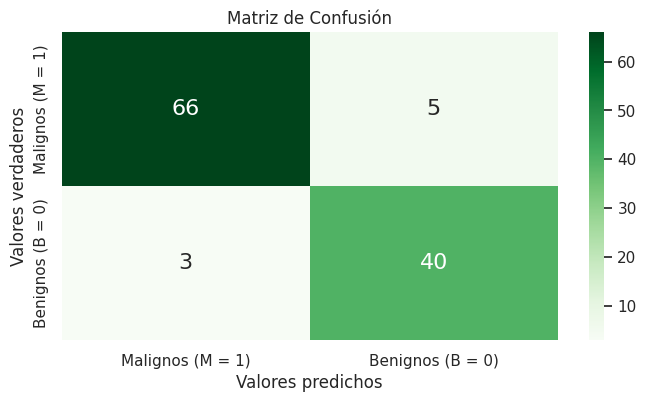

In [ ]:
# Matriz de confusión
y_pred = model_cm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Crear la figura y el eje
plt.figure(figsize=(8, 4))
sns.set(font_scale=1)

# Crear el heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", annot_kws={"size": 16},
            xticklabels=['Malignos (M = 1)', 'Benignos (B = 0)'],
            yticklabels=['Malignos (M = 1)', 'Benignos (B = 0)'])


# Añadir etiquetas y título
plt.ylabel('Valores verdaderos')
plt.xlabel('Valores predichos')
plt.title('Matriz de Confusión')

# Mostrar el plot
plt.show()

✅ **Verdaderos Positivos (VP)**: Es el número de casos que fueron clasificados correctamente como Malignos (M = 1) por el modelo. En este caso, hay 66 casos clasificados correctamente como Malignos.

❌ **Falsos Negativos (FN)**: Es el número de casos que fueron clasificados incorrectamente como Benignos (B = 0) pero que en realidad son Malignos (M = 1). Aquí, hay 5 casos que fueron clasificados como Benignos cuando en realidad son Malignos.

❌✅ **Falsos Positivos (FP)**: Es el número de casos que fueron clasificados incorrectamente como Malignos (M = 1) pero que en realidad son Benignos (B = 0). Hay 3 casos que fueron clasificados como Malignos cuando en realidad son Benignos.

✅❌**Verdaderos Negativos (VN)**: Es el número de casos que fueron clasificados correctamente como Benignos (B = 0) por el modelo. En este caso, hay 40 casos clasificados correctamente como Benignos.

### **Curva ROC** 📈

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


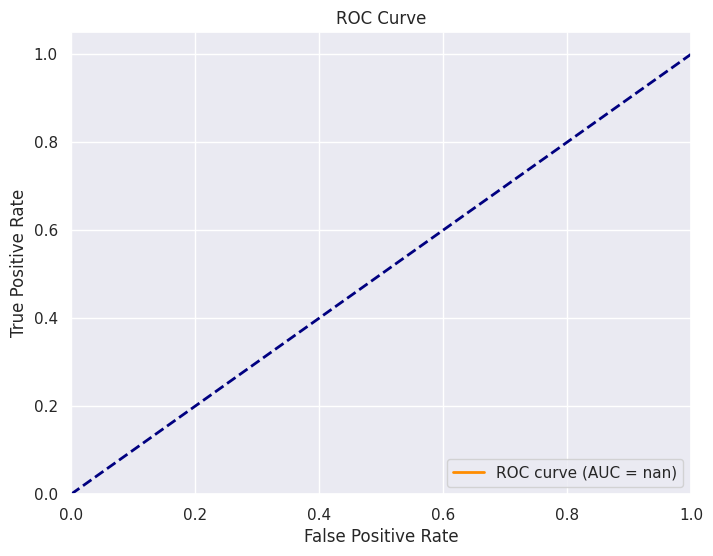

In [ ]:
# Graficando curva ROC
fpr, tpr, thresholds = roc_curve(y_test, model_cm.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

😲 Los valores de AUC-ROC están por encima de 0.98. Esto significa que el modelo tiene una muy buena capacidad para generalizar entre muestras benignas y malignas.

### **Validación Cruzada K-Folds** 📉

In [ ]:
# Validación cruzada
def valKFolds(X, y, cv_values, model, scoring=None):
    """
    Realiza la validación cruzada K-fold con diferentes valores de cv y muestra los resultados en una tabla.

    Parámetros:
    X (pandas.DataFrame): Matriz de características.
    y (pandas.Series): Variable objetivo.
    cv_values (list): Lista de valores de cv a probar.
    model (sklearn.base.BaseEstimator): Modelo a utilizar (por defecto, LogisticRegression).
    scoring (dict o None): Diccionario de métricas de evaluación a utilizar (por defecto, None).
    """
    # Inicializar una lista para almacenar los resultados
    results = []

    # Iterar sobre los diferentes valores de cv
    for cv in cv_values:
        print(f"Evaluación con K-fold Cross-Validation (cv={cv}):")
        scores = cross_validate(model, X, y, cv=cv, scoring=scoring)

        # Agregar los resultados a la lista
        results.append({
            '# Particiones': cv,
            'Accuracy': scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall': scores['test_recall'].mean(),
            'F1-score': scores['test_f1'].mean(),
            'AUC-ROC': scores['test_roc_auc'].mean()
        })

    # Crear un DataFrame con los resultados
    results_df = pd.DataFrame(results)
    return results_df

cv_values = [2, 3, 4, 8, 16, 32, 40]
result = valKFolds(X_scaled, y, cv_values, model, scoring=scoring)

result

Evaluación con K-fold Cross-Validation (cv=2):
Evaluación con K-fold Cross-Validation (cv=3):


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sk

Evaluación con K-fold Cross-Validation (cv=4):


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sk

Evaluación con K-fold Cross-Validation (cv=8):


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sk

Evaluación con K-fold Cross-Validation (cv=16):


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sk

Evaluación con K-fold Cross-Validation (cv=32):


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sk

Evaluación con K-fold Cross-Validation (cv=40):


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sk

,# Particiones,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,2,0.920972,NaN,NaN,NaN,0.982942
1,3,0.924487,NaN,NaN,NaN,0.983724
2,4,0.921009,NaN,NaN,NaN,0.983289
3,8,0.926154,NaN,NaN,NaN,0.983325
4,16,0.928175,NaN,NaN,NaN,0.982295
5,32,0.928309,NaN,NaN,NaN,0.983462
6,40,0.928690,NaN,NaN,NaN,0.983426


🔄 Validación cruzada usando K-fold

### **Validación Stratified K-Folds** ❎

In [ ]:
# Validación cruzada Estratificada
def valStratifiedKFold(X, y, n_splits, model, shuffle=True, scoring=None):
    """
    Realiza la validación cruzada K-fold con diferentes valores de cv y muestra los resultados en una tabla.

    Parámetros:
    X (pandas.DataFrame): Matriz de características.
    y (pandas.Series): Variable objetivo.
    n_splits (list): Lista de valores de cv a probar.
    model (sklearn.base.BaseEstimator): Modelo a utilizar (por defecto, LogisticRegression).
    scoring (dict o None): Diccionario de métricas de evaluación a utilizar (por defecto, None).
    """
    # Inicializar una lista para almacenar los resultados
    results = []

    # Iterar sobre los diferentes valores de cv
    for cv in n_splits:
        print(f"Evaluación con Stratified K-fold Cross-Validation (cv={cv}):")
        skf = StratifiedKFold(n_splits=cv, shuffle=shuffle, random_state=42)
        scores = cross_validate(model, X, y, cv=skf, scoring=scoring)

        # Agregar los resultados a la lista
        results.append({
            '# Particiones': cv,
            'Accuracy': scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall': scores['test_recall'].mean(),
            'F1-score': scores['test_f1'].mean(),
            'AUC-ROC': scores['test_roc_auc'].mean()
        })

    # Crear un DataFrame con los resultados
    results_df = pd.DataFrame(results)
    return results_df

n_splits = [2, 3, 4, 8, 16, 32, 40]
result = valStratifiedKFold(X_scaled, y, n_splits, model, scoring=scoring)

result

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sk

Evaluación con Stratified K-fold Cross-Validation (cv=2):
Evaluación con Stratified K-fold Cross-Validation (cv=3):
Evaluación con Stratified K-fold Cross-Validation (cv=4):
Evaluación con Stratified K-fold Cross-Validation (cv=8):


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sk

Evaluación con Stratified K-fold Cross-Validation (cv=16):


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sk

Evaluación con Stratified K-fold Cross-Validation (cv=32):


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sk

Evaluación con Stratified K-fold Cross-Validation (cv=40):


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2098, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sklea

,# Particiones,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,2,0.927947,NaN,NaN,NaN,0.981585
1,3,0.929722,NaN,NaN,NaN,0.983102
2,4,0.926130,NaN,NaN,NaN,0.984283
3,8,0.929626,NaN,NaN,NaN,0.985926
4,16,0.929812,NaN,NaN,NaN,0.985662
5,32,0.930045,NaN,NaN,NaN,0.986359
6,40,0.929167,NaN,NaN,NaN,0.983704


🔄 Experimentando con la metodología de validación 'Stratified K-Folds'

### **Submuestreo y Sobremuestreo** 🔍

In [ ]:
# Sobremuestreo
smote = SMOTE()
X = data.drop(['ID', 'Diagnosis'], axis=1)
y = data['Diagnosis']
X_resampled_sob, y_resampled_sob = smote.fit_resample(X, y)
print(pd.Series(y_resampled_sob).value_counts())

Diagnosis
1    357
0    357
Name: count, dtype: int64


La técnica de sobremuestreo crea nuevas muestras sintéticas de la clase minoritaria (maligno = 1) para equilibrar la distribución.

In [ ]:
# Submuestreo
rus = RandomUnderSampler()
X_resampled_sub, y_resampled_sub = rus.fit_resample(X, y)

print('Distribución de clases después del rebalanceo:')
print(pd.Series(y_resampled_sub).value_counts())

Distribución de clases después del rebalanceo:
Diagnosis
0    212
1    212
Name: count, dtype: int64


Luego, aplicamos el submuestreo, que elimina aleatoriamente algunas muestras de la clase mayoritaria (benigno = 0) para equilibrar la distribución.

In [ ]:
model_LR = LogisticRegression(max_iter=10000)
n_splits = [2, 3, 4, 8, 16, 32, 40]
result = valStratifiedKFold(X_resampled_sob, y_resampled_sob, n_splits, model_LR, scoring=scoring)

result

Evaluación con Stratified K-fold Cross-Validation (cv=2):
Evaluación con Stratified K-fold Cross-Validation (cv=3):
Evaluación con Stratified K-fold Cross-Validation (cv=4):
Evaluación con Stratified K-fold Cross-Validation (cv=8):
Evaluación con Stratified K-fold Cross-Validation (cv=16):
Evaluación con Stratified K-fold Cross-Validation (cv=32):
Evaluación con Stratified K-fold Cross-Validation (cv=40):


,# Particiones,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,2,0.952381,0.957619,0.946802,0.952111,0.992468
1,3,0.960784,0.968700,0.952381,0.960389,0.993433
2,4,0.957975,0.968586,0.946816,0.957546,0.992029
3,8,0.956617,0.963265,0.949621,0.956091,0.991439
4,16,0.960732,0.970416,0.952693,0.959874,0.992948
5,32,0.960907,0.968240,0.955729,0.959980,0.992726
6,40,0.960784,0.968264,0.955208,0.959596,0.993094


In [ ]:
n_splits = [2, 3, 4, 8, 16, 32, 40]
result = valStratifiedKFold(X_resampled_sub, y_resampled_sub, n_splits, model_LR, scoring=scoring)

result

Evaluación con Stratified K-fold Cross-Validation (cv=2):
Evaluación con Stratified K-fold Cross-Validation (cv=3):
Evaluación con Stratified K-fold Cross-Validation (cv=4):
Evaluación con Stratified K-fold Cross-Validation (cv=8):
Evaluación con Stratified K-fold Cross-Validation (cv=16):
Evaluación con Stratified K-fold Cross-Validation (cv=32):
Evaluación con Stratified K-fold Cross-Validation (cv=40):


,# Particiones,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,2,0.945755,0.965618,0.924528,0.944483,0.989231
1,3,0.957513,0.966385,0.948021,0.957037,0.991163
2,4,0.950472,0.966305,0.933962,0.949473,0.990655
3,8,0.962264,0.971796,0.952813,0.961677,0.991275
4,16,0.962251,0.968750,0.957761,0.962024,0.993845
5,32,0.959821,0.974144,0.947173,0.956978,0.994260
6,40,0.960000,0.974762,0.948333,0.958607,0.990667
